In [37]:
import requests
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import math
import aiohttp
import httpx
import asyncio
import ujson as json
from datetime import datetime
import re
import time
import os
import sys
import matplotlib.pyplot as plt
import random
import string
import QuantLib as ql
from scipy.optimize import minimize
from itertools import groupby
from operator import itemgetter
from typing import List, Optional, Dict, TypeAlias

from dotenv import dotenv_values
config = dotenv_values(".env")

from CUSIP_Curve import CUSIP_Curve
from CurveInterpolator import CurveInterpolator
from utils.utils import get_otr_cusips_by_date, get_otr_date_ranges, quantlib_date_to_pydatetime
from utils.fred import Fred

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def temp_tester_httpx(dates):
    async def build_tasks(client: httpx.AsyncClient, dates):
        tasks = await CUSIP_Curve(
            use_ust_issue_date=True, debug_verbose=True
        )._build_fetch_tasks_historical_cusip_prices_github(
            client=client, dates=dates, max_concurrent_tasks=len(dates)
        )
        return await asyncio.gather(*tasks)

    async def run_fetch_all(dates):
        max_connections = 100  
        limits = httpx.Limits(
            max_connections=max_connections, max_keepalive_connections=25
        )
        async with httpx.AsyncClient(limits=limits) as client:
            all_data = await build_tasks(client=client, dates=dates)
            return all_data

    results = asyncio.run(run_fetch_all(dates=dates))
    return dict(results)


def temp_tester_aio(start, end, cusips):
    async def build_tasks(session: aiohttp.ClientSession, start, end, cusips):
        tasks = await CUSIP_Curve._build_fetch_tasks_historical_trace_data(
            session=session, cusips=cusips, start_date=start, end_date=end
        )
        return await asyncio.gather(*tasks)

    async def run_fetch_all(start, end, cusips):
        async with aiohttp.ClientSession() as session:
            all_data = await build_tasks(
                session=session, cusips=cusips, start=start, end=end
            )
            return all_data

    results = asyncio.run(run_fetch_all(cusips=cusips, start=start, end=end))
    return results

In [5]:
cusip_curve_builder = CUSIP_Curve(use_ust_issue_date=True, error_verbose=True, fred_api_key=config["FRED_API_KEY"])

In [341]:
ts_df = cusip_curve_builder.cusips_timeseries(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 8, 20), cusips=["91282CFX4"])
ts_df

{'91282CFX4':           Date  bid_price  offer_price  mid_price  eod_price  bid_yield  \
 272 2024-01-02   99.59375    99.625000  99.609375   99.62500   4.960280   
 273 2024-01-03   99.62500    99.640625  99.632812   99.59375   4.925591   
 274 2024-01-04   99.59375    99.609375  99.601562   99.59375   4.965414   
 275 2024-01-05   99.62500    99.656250  99.640625   99.62500   4.930332   
 276 2024-01-08   99.62500    99.640625  99.632812   99.62500   4.931541   
 ..         ...        ...          ...        ...        ...        ...   
 428 2024-08-14   99.81250     0.000000  49.906250   99.81250   5.139428   
 429 2024-08-15   99.78125     0.000000  49.890625   99.78125   5.271305   
 430 2024-08-16   99.78125     0.000000  49.890625   99.81250   5.278729   
 431 2024-08-19   99.81250     0.000000  49.906250   99.81250   5.170409   
 432 2024-08-20   99.81250     0.000000  49.906250   99.81250   5.176994   
 
        offer_yield  eod_yield  
 272       4.924428   4.924428  
 273   

In [201]:
ct_yields_df = cusip_curve_builder.get_historical_ct_yields(
    start_date=datetime(2024, 1, 1),
    end_date=datetime(2024, 8, 19),
    use_bid_side=True,
    tenors=[
        "17-Week",
        "26-Week",
        "52-Week",
        "2-Year",
        "3-Year",
        "5-Year",
        "7-Year",
        "10-Year",
        "20-Year",
        "30-Year",
    ],
)
ct_yields_df

,Date,17-Week,26-Week,52-Week,2-Year,3-Year,5-Year,7-Year,10-Year,20-Year,30-Year
0,2024-01-02,5.472211,5.318990,4.836896,4.316255,4.078661,3.902990,3.930496,3.929268,4.236789,4.071639
1,2024-01-03,5.461484,5.308014,4.847551,4.349490,4.112347,3.938005,3.961727,3.959184,4.268232,4.108749
2,2024-01-04,5.450768,5.280148,4.869148,4.366379,4.122924,3.952247,3.982747,3.977641,4.283906,4.127351
3,2024-01-05,5.537664,5.307207,4.841772,4.333072,4.111297,3.945311,3.972380,3.985065,4.311072,4.156379
4,2024-01-08,5.440123,5.257859,4.835186,4.316409,4.076910,3.924346,3.956802,3.973625,4.290607,4.147783
...,...,...,...,...,...,...,...,...,...,...,...
151,2024-08-13,5.225933,5.024191,4.441981,3.955811,3.780115,3.693721,3.749294,3.862594,4.254967,4.167710
152,2024-08-14,5.247338,5.024011,4.419947,3.938537,3.745641,3.652185,3.703526,3.817151,4.204933,4.119046
153,2024-08-15,5.258048,5.068314,4.538977,4.104248,3.906361,3.803949,3.840516,3.932149,4.298374,4.194743
154,2024-08-16,5.341472,5.125790,4.564407,4.103835,3.906462,3.803834,3.835290,3.920683,4.279972,4.172844


In [221]:
cmt_yields_df = cusip_curve_builder.get_historical_cmt_yields(
    start_date=datetime(2005, 1, 1),
    end_date=datetime(2024, 8, 19),
    use_treasury_par=True,
    treasury_data_dir=r"C:\Users\chris\Curvy-CUSIPs\data\treasury",
    apply_long_term_extrapolation_factor=True,
    download_treasury_par_yields=True
)
cmt_yields_df

Fetching from treasury.gov...


,Date,4-Week,8-Week,13-Week,17-Week,26-Week,52-Week,2-Year,3-Year,5-Year,7-Year,10-Year,20-Year,30-Year
0,2006-01-03,4.05,NaN,4.16,NaN,4.40,4.38,4.34,4.30,4.30,4.32,4.37,4.62,4.52
1,2006-01-04,4.03,NaN,4.19,NaN,4.37,4.35,4.31,4.28,4.28,4.31,4.36,4.60,4.55
2,2006-01-05,4.05,NaN,4.20,NaN,4.37,4.36,4.32,4.29,4.29,4.31,4.36,4.61,4.51
3,2006-01-06,4.06,NaN,4.22,NaN,4.39,4.38,4.36,4.32,4.32,4.33,4.38,4.63,4.53
4,2006-01-09,4.09,NaN,4.23,NaN,4.40,4.39,4.36,4.32,4.32,4.34,4.38,4.63,4.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4659,2024-08-13,5.48,5.39,5.32,5.18,4.97,4.40,3.93,3.75,3.68,3.74,3.85,4.25,4.16
4660,2024-08-14,5.49,5.39,5.32,5.21,5.00,4.42,3.94,3.76,3.67,3.72,3.83,4.22,4.12
4661,2024-08-15,5.53,5.40,5.34,5.22,5.04,4.52,4.08,3.90,3.79,3.83,3.92,4.28,4.18
4662,2024-08-16,5.53,5.40,5.33,5.21,5.02,4.49,4.06,3.87,3.77,3.81,3.89,4.26,4.15


In [100]:
as_of_date = datetime(2024, 8, 20)
cs_df = cusip_curve_builder.build_curve_set(
    as_of_date=as_of_date,
    # calc_ytms=True,
    # use_quantlib=True,
    # include_auction_results=True,
    # include_soma_holdings=True,
    # include_stripping_activity=True,
    sorted=True,
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=["eod_price", "eod_yield"]
)
cs_df

,cusip,security_type,auction_date,issue_date,maturity_date,time_to_maturity,int_rate,high_investment_rate,is_on_the_run,label,security_term,original_security_term,eod_price,eod_yield,rank
0,912797KY2,Bill,2024-07-18,2024-07-23,2024-08-20,0.000000,NaN,5.365000,False,Aug 24s,4-Week,17-Week,NaN,NaN,17.0
1,912797KZ9,Bill,2024-07-25,2024-07-30,2024-08-27,0.019178,NaN,5.381000,False,Aug 24s,4-Week,17-Week,99.913167,5.340207,16.0
2,912797LA3,Bill,2024-08-01,2024-08-06,2024-09-03,0.038356,NaN,5.381000,False,Sep 24s,4-Week,17-Week,99.811139,5.423507,15.0
3,912797LG0,Bill,2024-08-08,2024-08-13,2024-09-10,0.057534,NaN,5.381000,False,Sep 24s,4-Week,17-Week,99.708889,5.436840,14.0
4,912797LH8,Bill,2024-08-15,2024-08-20,2024-09-17,0.076712,NaN,5.355000,False,Sep 24s,4-Week,17-Week,99.607750,5.429116,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389,912810TT5,Bond,2023-10-12,2023-10-16,2053-08-15,29.005479,4.125,NaN,False,Aug 53s,29-Year 10-Month,30-Year,100.531250,4.093483,4.0
390,912810TV0,Bond,2024-01-11,2024-01-16,2053-11-15,29.257534,4.750,NaN,False,Nov 53s,29-Year 10-Month,30-Year,111.468750,4.074765,3.0
391,912810TX6,Bond,2024-04-11,2024-04-15,2054-02-15,29.509589,4.250,NaN,False,Feb 54s,29-Year 10-Month,30-Year,102.781250,4.086783,2.0
392,912810UA4,Bond,2024-07-11,2024-07-15,2054-05-15,29.753425,4.625,NaN,False,May 54s,29-Year 10-Month,30-Year,109.375000,4.077646,1.0


In [127]:
filtered_cs_df = cs_df[(cs_df["rank"] == 0)]
# filtered_cs_df = cs_df[(cs_df["rank"] == 0)]
filtered_cs_df = filtered_cs_df[["issue_date", "maturity_date", "int_rate", "eod_price"]]
filtered_cs_df = filtered_cs_df.reset_index(drop=True)
filtered_cs_df

,issue_date,maturity_date,int_rate,eod_price
0,2024-08-20,2024-12-17,NaN,98.370944
1,2024-08-15,2025-02-13,NaN,97.672889
2,2024-08-08,2025-08-07,NaN,95.856250
3,2024-07-31,2026-07-31,4.375,100.687500
4,2024-08-15,2027-08-15,3.750,99.843750
5,2024-07-31,2029-07-31,4.000,101.343750
6,2024-07-31,2031-07-31,4.125,102.375000
7,2024-08-15,2034-08-15,3.875,100.468750
8,2024-07-31,2044-05-15,4.625,105.875000
9,2024-08-15,2054-08-15,4.250,103.062500


In [152]:
np.arange(0, 2, 1/12)

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667, 1.5       , 1.58333333,
       1.66666667, 1.75      , 1.83333333, 1.91666667])

In [144]:
spot_curve = cusip_curve_builder.get_spot_rates(curve_set_df=filtered_cs_df, as_of_date=as_of_date, on_rate=5.34, ql_bootstrap_methods=["ql_mlpcd"])
spot_curve

,maturity_date,time_to_maturity,spot_rate
0,2024-08-23,0.002778,5.340000
1,2024-12-17,0.319672,5.204552
2,2025-02-13,0.478464,4.982243
3,2025-08-07,0.957916,4.467135
4,2026-07-31,1.938738,3.991531
5,2027-08-16,2.982574,3.791648
6,2029-07-31,4.938738,3.685078
7,2031-07-31,6.938738,3.726629
8,2034-08-15,9.979834,3.826959
9,2044-05-16,19.732240,4.294740


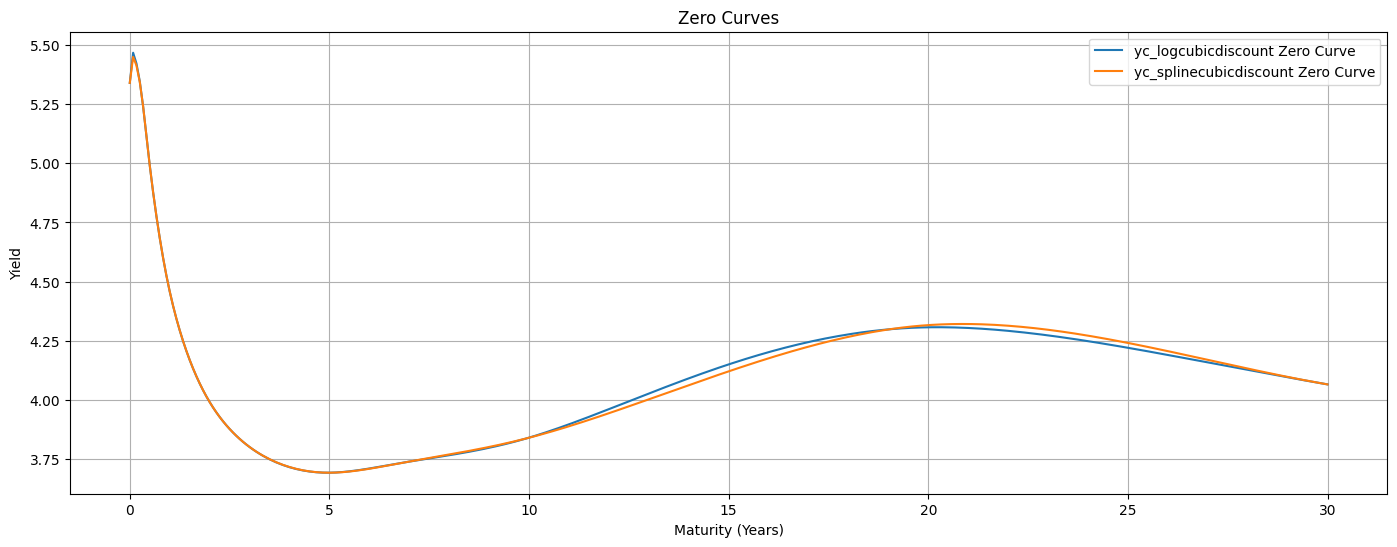

In [145]:
plt.figure(figsize=(17, 6))
plt.plot(yc_logcubicdiscount_spot_df["Maturities"], yc_logcubicdiscount_spot_df["Curve"], label=f"yc_logcubicdiscount Zero Curve")
plt.plot(yc_splinecubicdiscount_spot_df["Maturities"], yc_splinecubicdiscount_spot_df["Curve"], label=f"yc_splinecubicdiscount Zero Curve")
plt.title(f"Zero Curves")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.grid(True)
plt.legend()
plt.show()

In [82]:
def calculate_par_rate(quantlib_zero_curve: ql.FittedBondDiscountCurve, maturity: int | float):
    periods = maturity * 2
    spot_rates = [quantlib_zero_curve.zeroRate(t / 2, ql.Continuous).rate() for t in range(1, periods + 1)]
    discount_factors = [1 / (1 + s / 2)**t for s, t in zip(spot_rates, range(1, periods + 1))]
    sum_of_dfs = sum(discount_factors)
    par_rate = (100 - 100 * discount_factors[-1]) / sum_of_dfs * 2
    return par_rate

# def calculate_par_rate(quantlib_curve: ql.FittedBondDiscountCurve, maturity: int):
#     spot_rates = [quantlib_curve.zeroRate(t, ql.Continuous).rate() for t in range(1, maturity + 1)]
#     discount_factors = [1 / (1 + s)**t for s, t in zip(spot_rates, range(1, maturity + 1))]
#     sum_of_dfs = sum(discount_factors)
#     par_rate = (100 - 100 * discount_factors[-1]) / sum_of_dfs
#     return par_rate

In [83]:
calculate_par_rate(quantlib_zero_curve=curve, maturity=30)

6.760691958021794

In [130]:
from models.calibrate import (
    calibrate_ns_ols,
    calibrate_nss_ols,
    calibrate_bc_ols,
    calibrate_bc_augmented_ols,
    calibrate_diebold_li_ols,
    calibrate_mles_ols,
    calibrate_pca_yield_curve,
    calibrate_smith_wilson_ols,
)

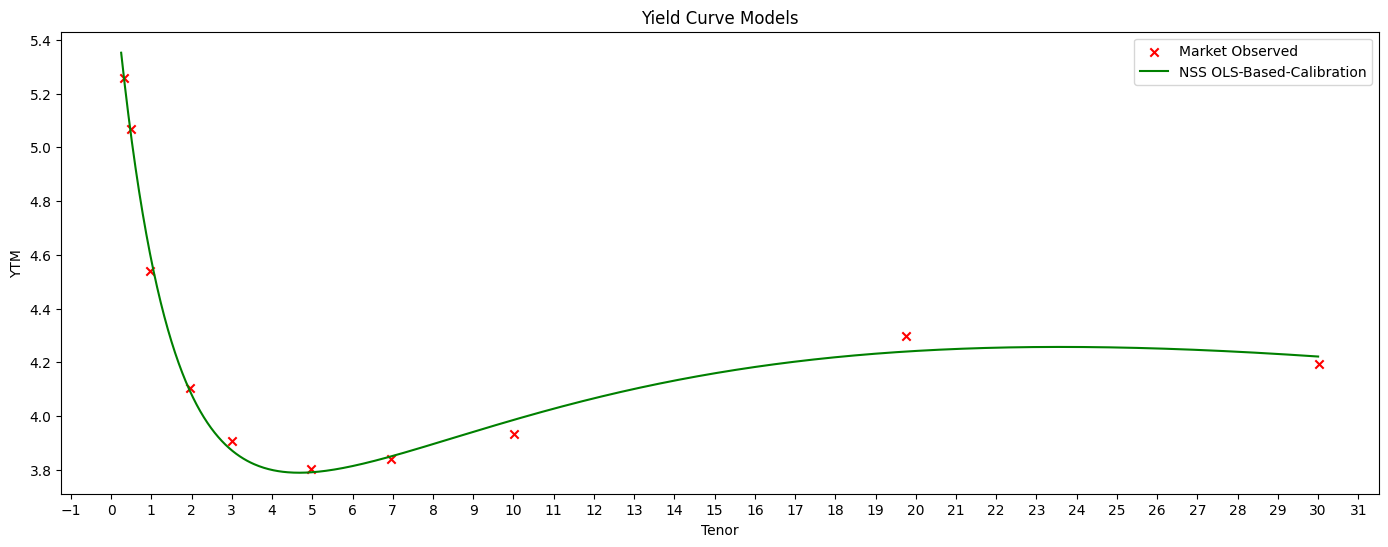

In [132]:
maturities = np.array(
    [
        0.32054794520547947,
        0.4986301369863014,
        0.9780821917808219,
        1.9589041095890412,
        3.0,
        4.961643835616439,
        6.961643835616439,
        10.005479452054795,
        19.76164383561644,
        30.019178082191782,
    ]
)

yields = np.array(
    [
        5.258047907623223,
        5.068313806703524,
        4.538977465708812,
        4.104248469556026,
        3.906360694376456,
        3.8039494327325727,
        3.8405160868389356,
        3.9321489548631066,
        4.298374133968205,
        4.1947433231346425,
    ]
)

curve_ns, status_ns = calibrate_ns_ols(
    maturities,
    yields,
    tau0=1.0,
)
assert status_ns.success

curve_nss, status_nss = calibrate_nss_ols(
    maturities,
    yields,
)
assert status_nss.success

curve_bc, status_bc = calibrate_bc_ols(maturities, yields)
assert status_bc.success

curve_bca, status_bca = calibrate_bc_augmented_ols(maturities, yields)
assert status_bca.success

curve_di, status_di = calibrate_diebold_li_ols(maturities, yields)
assert status_di.success

curve_mlesm, status_mlesm = calibrate_mles_ols(maturities, yields, overnight_rate=5.34)
# assert status_mlesm.success

ufr = None
curve_sw, status_sw = calibrate_smith_wilson_ols(maturities, yields, ufr=ufr, overnight_rate=5.34)
assert status_sw.success

t2 = np.linspace(0.25, 30, 1000)
plt.figure(figsize=(17, 6))
plt.scatter(
    maturities,
    yields,
    marker="x",
    color="red",
    label="Market Observed",
)
# plt.plot(t2, curve_ns(t2), "b-", label="NS OLS-Based-Calibration")
plt.plot(t2, curve_nss(t2), "g-", label="NSS OLS-Based-Calibration")
# plt.plot(t2, curve_bc(t2), label="Bjork-Christensen OLS-Based Calibration")
# plt.plot(t2, [mc.spot(t) for t in t2], label="mc")
# plt.plot(t2, curve_bca(t2), label="Bjork-Christensen-Augmented OLS-Based Calibration")
# plt.plot(t2, curve_di(t2), label="Diebold-Li OLS-Based Calibration")
# plt.plot(t2, curve_mlesm(t2), label="MLESM OLS-Based Calibration")
# plt.plot(t2, curve_sw(t2), label="Smith-Wilson OLS-Based Calibration")

plt.title("Yield Curve Models")
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.xlabel("Tenor")
plt.ylabel("YTM")
plt.legend()
plt.show()

In [134]:
discount_factors = np.exp(-curve_nss(t2) * t2)
spot_rates = -np.log(discount_factors) / t2 
spot_rates_percent = spot_rates
spot_rate_df = pd.DataFrame({
    'Maturity (Years)': t2,
    'Spot Rate (%)': spot_rates_percent
})

print(spot_rate_df)

     Maturity (Years)  Spot Rate (%)
0            0.250000       5.352374
1            0.279780       5.311507
2            0.309560       5.271654
3            0.339339       5.232791
4            0.369119       5.194891
..                ...            ...
995         29.880881       4.222559
996         29.910661       4.222262
997         29.940440       4.221964
998         29.970220       4.221665
999         30.000000       4.221364

[1000 rows x 2 columns]
